   - Logistic regression this ROc UC
   - KNN 
   - Decision tree
   - Random forest
   - Adaboost
   - XGBoost this
   - SVMs
   - Naive Bayes
   
   pledge/ratio

In [1]:
import pandas as pd
import numpy as np
import json
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
# from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
# from sklearn.preprocessing import LabelEncoder
# from sklearn.preprocessing import LabelBinarizer
import xgboost as xgb
from sklearn.metrics import roc_curve, auc, roc_auc_score

In [2]:
with open('cleaned_data.json') as json_file:
    data = json.load(json_file)

In [3]:
df = pd.read_json(data)

### Ensure Data Was Imported Correctly

In [4]:
df.shape

(5424, 25)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5424 entries, 0 to 999
Data columns (total 25 columns):
backers_count               5424 non-null int64
converted_pledged_amount    5424 non-null int64
country                     5424 non-null object
created_at                  5424 non-null datetime64[ns]
currency                    5424 non-null object
current_currency            5424 non-null object
deadline                    5424 non-null int64
disable_communication       5424 non-null bool
fx_rate                     5424 non-null float64
goal                        5424 non-null int64
id                          5424 non-null int64
is_starrable                5424 non-null bool
launched_at                 5424 non-null datetime64[ns]
name                        5424 non-null object
pledged                     5424 non-null float64
spotlight                   5424 non-null bool
staff_pick                  5424 non-null bool
state                       5424 non-null object
state_c

In [6]:
df.head(1)

,backers_count,converted_pledged_amount,country,created_at,currency,current_currency,deadline,disable_communication,fx_rate,goal,...,spotlight,staff_pick,state,state_changed_at,static_usd_rate,urls,usd_pledged,cat_name,cat_slug,loc_state
0,6,1847,GB,2015-04-03,GBP,USD,1430956800000,False,1.30399,7000,...,False,False,canceled,2015-04-19,1.491538,"{""web"":{""project"":""https://www.kickstarter.com...",1842.049134,Ready-to-wear,fashion/ready-to-wear,England


In [7]:
df['deadline'] = pd.to_datetime(df['deadline'], unit='ms')
df['deadline'] = pd.to_datetime(df['deadline'].dt.date)

In [8]:
# Get names of indexes for which column Age has value 30 #
indexNames = df[(df['state'] == 'canceled')|(df['state'] == 'live')|(df['state'] == 'suspended')].index
# Delete these row indexes from dataFrame
df.drop(indexNames,0,inplace=True)

In [9]:
df['state'].value_counts()

successful    3025
failed        1931
Name: state, dtype: int64

In [10]:
df.reset_index(drop=True, inplace=True)

### Create new features

In [11]:
df['time_allowed'] = df['state_changed_at']-df['created_at']

In [12]:
df.time_allowed = df.time_allowed.dt.days

In [13]:
df['pledge/goal'] = (df['converted_pledged_amount']/df['goal'])

In [14]:
df['goal/time_allowed'] = (df['goal']/df['time_allowed'])

In [15]:
df.head(26);

In [16]:
df.goal.describe()

count    4.956000e+03
mean     4.938443e+04
std      1.450516e+06
min      1.000000e+00
25%      1.500000e+03
50%      5.000000e+03
75%      1.300000e+04
max      1.000000e+08
Name: goal, dtype: float64

In [17]:
df.time_allowed.describe()

count    4956.000000
mean       80.369451
std       130.615077
min         4.000000
25%        33.000000
50%        46.000000
75%        71.000000
max      2431.000000
Name: time_allowed, dtype: float64

In [19]:
df['pledge/goal'].describe()

count     4956.000000
mean         4.691728
std        179.886625
min          0.000000
25%          0.039000
50%          1.024469
75%          1.357143
max      12575.000000
Name: pledge/goal, dtype: float64

In [20]:
outliers_index = list((df[df['pledge/goal'] > 2].index)|(df[df['goal'] >= 0.2e+08].index)|((df[df['time_allowed'] >= 1500].index)))

In [21]:
len(outliers_index)

663

In [22]:
df.drop(outliers_index,0,inplace=True)

In [23]:
df.reset_index(drop=True, inplace=True)

In [24]:
df.shape

(4293, 28)

In [25]:
df['pledge/goal'].describe()

count    4293.000000
mean        0.692039
std         0.607994
min         0.000000
25%         0.016667
50%         1.000000
75%         1.160222
max         2.000000
Name: pledge/goal, dtype: float64

(array([1704.,  186.,   64.,   82.,   91., 1230.,  428.,  248.,  169.,
          91.]),
 array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2, 1.4, 1.6, 1.8, 2. ]),
 <a list of 10 Patch objects>)

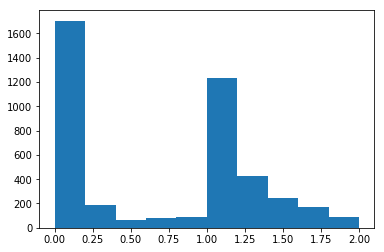

In [26]:
plt.hist(df['pledge/goal'], bins=10)

In [27]:
# first, create bins for based on the values observed. 5 values will result in 4 bins
bins = [-0.01, 0.5, 1 , 1.5, 2.01]
# use pd.cut
bins_pledgeGoal = pd.cut(df['pledge/goal'], bins)

In [28]:
bins_pledgeGoal = bins_pledgeGoal.cat.as_ordered()

In [29]:
df["pledge/goal"]=bins_pledgeGoal

In [30]:
df["pledge/goal"]

0         (1.0, 1.5]
1       (-0.01, 0.5]
2       (-0.01, 0.5]
3         (1.0, 1.5]
4         (1.0, 1.5]
5         (1.0, 1.5]
6       (-0.01, 0.5]
7         (1.0, 1.5]
8         (1.0, 1.5]
9         (1.0, 1.5]
10       (1.5, 2.01]
11      (-0.01, 0.5]
12      (-0.01, 0.5]
13      (-0.01, 0.5]
14      (-0.01, 0.5]
15      (-0.01, 0.5]
16        (1.0, 1.5]
17        (1.0, 1.5]
18        (1.0, 1.5]
19       (1.5, 2.01]
20        (1.0, 1.5]
21        (1.0, 1.5]
22        (1.0, 1.5]
23        (1.0, 1.5]
24        (1.0, 1.5]
25      (-0.01, 0.5]
26        (1.0, 1.5]
27      (-0.01, 0.5]
28        (1.0, 1.5]
29        (0.5, 1.0]
            ...     
4263      (1.0, 1.5]
4264      (1.0, 1.5]
4265      (1.0, 1.5]
4266    (-0.01, 0.5]
4267    (-0.01, 0.5]
4268    (-0.01, 0.5]
4269    (-0.01, 0.5]
4270    (-0.01, 0.5]
4271      (1.0, 1.5]
4272      (1.0, 1.5]
4273     (1.5, 2.01]
4274    (-0.01, 0.5]
4275    (-0.01, 0.5]
4276      (1.0, 1.5]
4277      (1.0, 1.5]
4278     (1.5, 2.01]
4279    (-0.0

In [31]:
df.isna().sum()

backers_count               0
converted_pledged_amount    0
country                     0
created_at                  0
currency                    0
current_currency            0
deadline                    0
disable_communication       0
fx_rate                     0
goal                        0
id                          0
is_starrable                0
launched_at                 0
name                        0
pledged                     0
spotlight                   0
staff_pick                  0
state                       0
state_changed_at            0
static_usd_rate             0
urls                        0
usd_pledged                 0
cat_name                    0
cat_slug                    0
loc_state                   0
time_allowed                0
pledge/goal                 0
goal/time_allowed           0
dtype: int64

In [ ]:
# Pick contineous features

In [32]:
X_c = df[['time_allowed','goal', 'backers_count']]

In [33]:
# Pick categotical features

In [34]:
X_d = pd.get_dummies(df[['cat_slug', 'country', 'spotlight', 'staff_pick', 'pledge/goal']], drop_first=True, prefix_sep='_')

In [35]:
X_d.rename(columns={'pledge/goal_(0.5, 1.0]': 'p/g_low','pledge/goal_(1.0, 1.5]': 'p/g_high', 'pledge/goal_(1.5, 2.01]': 'p/g_vhigh'}, inplace=True)

In [36]:
X_d.head(1)

,spotlight,staff_pick,cat_slug_art/ceramics,cat_slug_art/conceptual art,cat_slug_art/digital art,cat_slug_art/illustration,cat_slug_art/installations,cat_slug_art/mixed media,cat_slug_art/painting,cat_slug_art/performance art,...,country_MX,country_NL,country_NO,country_NZ,country_SE,country_SG,country_US,p/g_low,p/g_high,p/g_vhigh
0,True,False,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,1,0


In [37]:
# Join Features
X = pd.concat([X_c,X_d],1)

In [38]:
# Set target to binary
y = pd.get_dummies(df[['state']], drop_first=True)

In [39]:
y;

In [40]:
X.isna().sum().sum()

0

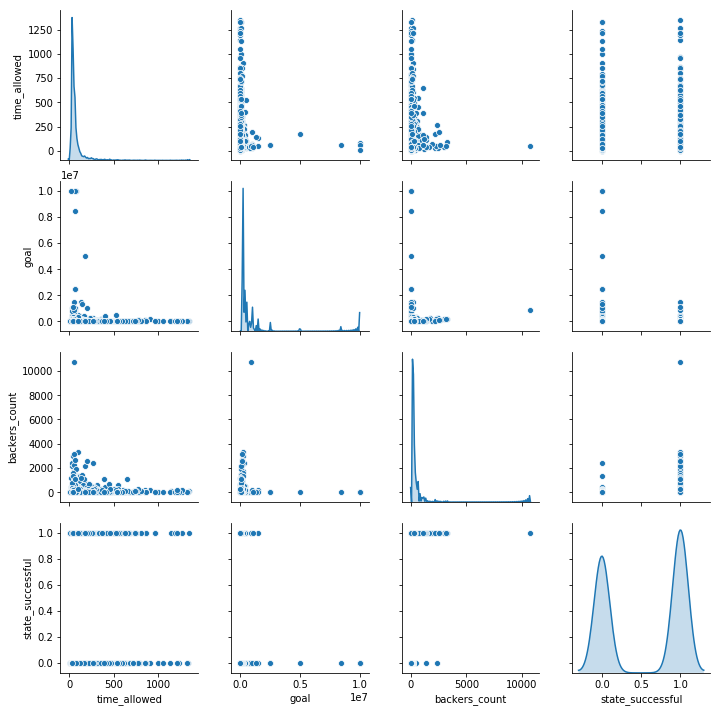

In [41]:
# Plot pair relationships
sns.pairplot(pd.concat([X_c,y],1), diag_kind="kde", height=2.5)

In [42]:
(pd.concat([X_c,y],1)).corr()

,time_allowed,goal,backers_count,state_successful
time_allowed,1.000000,0.003096,0.039044,0.011552
goal,0.003096,1.000000,0.035038,-0.069416
backers_count,0.039044,0.035038,1.000000,0.232803
state_successful,0.011552,-0.069416,0.232803,1.000000


## Split, Train, Test

In [43]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25)

## Random Forest

In [45]:
# hyperparameter tuning

In [ ]:
array32 = list(range(1,32))
clf_list = []
for i in array32:
    clf_choc = RandomForestClassifier(criterion='entropy', max_depth=i)  # Train the classifier using training data 
    clf_list.append(clf_choci.fit(X_train, y_train))
auc_list_test = []
for i in clf_list:
    y_pred1 = i.predict(X_test)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
    auc_list_test.append(auc(false_positive_rate, true_positive_rate))

In [ ]:
plt.figure(figsize=(12,6))
plt.plot(array32, auc_list_test, 'b', label='Test AUC')
plt.plot(array32, auc_list_train, 'r', label='Train AUC')
plt.ylabel('AUC score')
plt.xlabel('Tree depth')
plt.legend()
plt.show()

In [ ]:
array1 = list(map(lambda x: round(x,1), np.arange(0.1,1.0,0.1)))
clf_list_strawberry = []
for i in array1:
    clf_strawberryi = DecisionTreeClassifier(criterion='entropy', min_samples_split = i)  # Train the classifier using training data 
    clf_list_strawberry.append(clf_strawberryi.fit(X_train, y_train))
auc_list_test_strawberry = []
for i in clf_list_strawberry:
    y_pred = i.predict(X_test)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
    auc_list_test_strawberry.append(auc(false_positive_rate, true_positive_rate))
auc_list_train_strawberry = []
for i in clf_list_strawberry:
    y_pred = i.predict(X_train)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, y_pred)
    auc_list_train_strawberry.append(auc(false_positive_rate, true_positive_rate))

In [ ]:
plt.figure(figsize=(12,6))
plt.plot(array1, auc_list_test_strawberry, 'b', label='Test AUC')
plt.plot(array1, auc_list_train_strawberry, 'r', label='Train AUC')
plt.ylabel('AUC score')
plt.xlabel('Tree depth')
plt.legend()
plt.show()

In [46]:
forest = RandomForestClassifier(n_estimators=5, max_features=5, max_depth= 5)
forest.fit(X_train, y_train)

/Users/flatironschool/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=5, max_features=5, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=5,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [47]:
y_hat_train_rf = forest.predict(X_train)

In [48]:
y_hat_test_rf = forest.predict(X_test)

In [49]:
forest.feature_importances_;

In [50]:
accuracy_score(y_train, y_hat_train_rf)

0.9002795899347623

In [51]:
accuracy_score(y_test, y_hat_test_rf)

0.8864059590316573

In [52]:
print(confusion_matrix(y_test, y_hat_test_rf))

[[378  90]
 [ 32 574]]


## Logistic Regression

In [ ]:
hyperparameter tuing

In [53]:
logreg = LogisticRegression(fit_intercept = False, C = 1e12, solver='liblinear')
model_log = logreg.fit(X_train, y_train)

/Users/flatironschool/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [54]:
y_score = logreg.decision_function(X_test)

In [55]:
y_hat_test_lr = logreg.predict(X_test)
y_hat_train_lr = logreg.predict(X_train)

In [56]:
fpr, tpr, thresholds = roc_curve(y_test, y_score)

In [57]:
print('AUC: {}'.format(auc(fpr, tpr)))

AUC: 0.9327522495839327


In [58]:
print(confusion_matrix(y_test, y_hat_test_lr))

[[391  77]
 [ 43 563]]


In [59]:
accuracy_score(y_test, y_hat_test_lr)

0.888268156424581

AUC: 0.9327522495839327


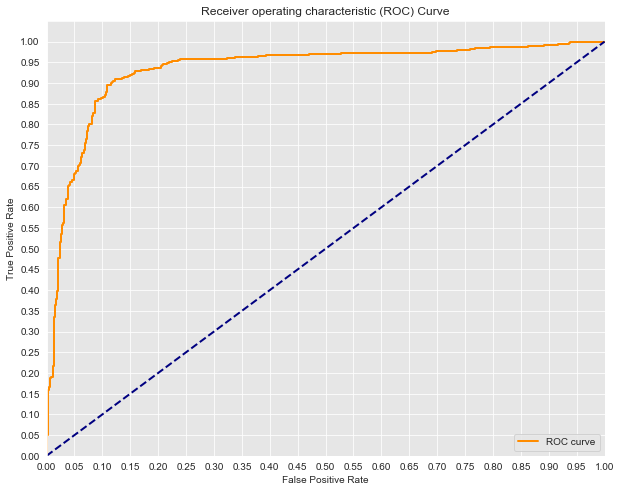

In [60]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

#Seaborns Beautiful Styling
sns.set_style("darkgrid", {"axes.facecolor": ".9"})

print('AUC: {}'.format(auc(fpr, tpr)))
plt.figure(figsize=(10,8))
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve')
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.yticks([i/20.0 for i in range(21)])
plt.xticks([i/20.0 for i in range(21)])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

## XGBoost

In [66]:
#hyperparameter tuing

In [65]:
XGBoost = xgb.XGBClassifier()
XGBoost.fit(X_train, y_train)
y_hat_train = XGBoost.predict(X_train)
y_hat_test = XGBoost.predict(X_test)
training_accuracy = accuracy_score(y_train, y_hat_train)
val_accuracy = accuracy_score(y_test, y_hat_test)

print("")
print("Training Accuracy: {:.4}%".format(training_accuracy * 100))
print("Validation accuracy: {:.4}%".format(val_accuracy * 100))

/Users/flatironschool/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/flatironschool/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



Training Accuracy: 100.0%
Validation accuracy: 100.0%


In [63]:
param_grid = {
    "learning_rate": [0.1],
    'max_depth': [6],
    'min_child_weight': [10],
    'subsample': [ 0.7],
    'n_estimators': [5, 30, 100, 250],
}

In [64]:
grid_clf = GridSearchCV(XGBoost, param_grid, scoring='accuracy', cv=None, n_jobs=1)
grid_clf.fit(X, y)

best_parameters = grid_clf.best_params_

print("Grid Search found the following optimal parameters: ")
for param_name in sorted(best_parameters.keys()):
    print("%s: %r" % (param_name, best_parameters[param_name]))

y_hat_train = grid_clf.predict(X_train)
y_hat_test = grid_clf.predict(X_test)
training_accuracy = accuracy_score(y_train, y_hat_train)
val_accuracy = accuracy_score(y_test, y_hat_test)

print("")
print("Training Accuracy: {:.4}%".format(training_accuracy * 100))
print("Validation accuracy: {:.4}%".format(val_accuracy * 100))

/Users/flatironschool/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
/Users/flatironschool/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/flatironschool/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/flatironschool/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/label.py:219: DataConversionWarning: A column-vector y was passed when a 1d ar

Grid Search found the following optimal parameters: 
learning_rate: 0.1
max_depth: 6
min_child_weight: 10
n_estimators: 5
subsample: 0.7

Training Accuracy: 100.0%
Validation accuracy: 100.0%
